In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

# Momentum Trading Strategy

## Download Data

In [2]:
# Getting the Nasdaq 100 ticker symbols from Wikipedia
nas_df = pd.read_html("https://en.wikipedia.org/wiki/Nasdaq-100")[4]
tickers = nas_df.Ticker.to_list()

In [6]:
# Download the Nasdaq 100 Adjusted Close price data with yfinance
df = yf.download(tickers, start="2010-01-01")["Adj Close"]

[*********************100%***********************]  101 of 101 completed


In [4]:
#df = df.dropna(axis=1)

## Basic

In [7]:
# Calculate monthly return
mtl = (df.pct_change() + 1)[1:].resample('M').prod()

In [8]:
def get_rolling_ret(df, n):
    return df.rolling(n).apply(np.prod)

In [9]:
ret_12 = get_rolling_ret(mtl, 12)
ret_6 = get_rolling_ret(mtl, 6)
ret_3 = get_rolling_ret(mtl, 3)

In [10]:
def get_top(date):
    top_50 = ret_12.loc[date].nlargest(50).index
    top_30 = ret_6.loc[date, top_50].nlargest(30).index
    return ret_3.loc[date, top_30].nlargest(10).index

In [11]:
def pf_performance(date):
    portfolio = mtl.loc[date:, get_top(date)][1:2]
    return portfolio.mean(axis=1).values[0]

In [12]:
returns = []

for date in mtl.index[12:-1]:
    returns.append(pf_performance(date))

41.46


<AxesSubplot: xlabel='Date'>

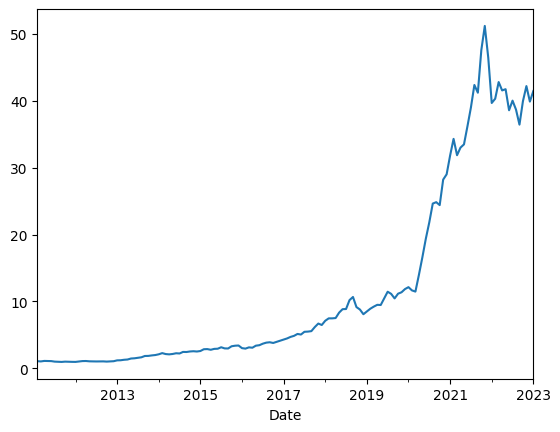

In [13]:
ret_df = pd.Series(returns,index=mtl.index[13:])
ret_p = ret_df.cumprod()[-1]
print(f"{ret_p:.2f}")
ret_df.cumprod().plot()

## High - Low

In [14]:
df = yf.download(tickers, start="2010-01-01")

[*********************100%***********************]  101 of 101 completed


In [15]:

# Grouping the monthly high, low, and close
close = df['Close'].groupby(by=pd.Grouper(freq='M')).last()
high = df['High'].groupby(by=pd.Grouper(freq='M')).max()
low = df['Low'].groupby(by=pd.Grouper(freq='M')).min()

In [59]:
sl = 2.2
diff_c = close / close.shift(1)
diff_h = high / close.shift(1)
mask = diff_h > sl
mtl_h = diff_h.copy()
mtl_h[mask] = sl
mtl_h[~mask] = diff_c[~mask]

In [60]:
ret_12 = get_rolling_ret(diff_h, 12)
ret_6 = get_rolling_ret(diff_h, 6)
ret_3 = get_rolling_ret(diff_h, 3)

def get_top(date):
    top_50 = ret_12.loc[date].nlargest(50).index
    top_30 = ret_6.loc[date, top_50].nlargest(30).index
    return ret_3.loc[date, top_30].nlargest(10).index

In [61]:
def pf_performance(date):
    portfolio = mtl_h.loc[date:, get_top(date)][1:2]
    return portfolio.mean(axis=1).values[0]

In [62]:
returns = []

for date in mtl_h.index[12:-1]:
    returns.append(pf_performance(date))

53.76


<AxesSubplot: xlabel='Date'>

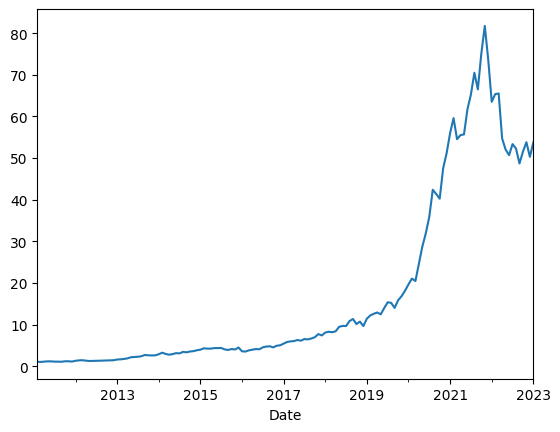

In [63]:
ret_df = pd.Series(returns,index=mtl.index[13:])
ret_p = ret_df.cumprod()[-1]
print(f"{ret_p:.2f}")
ret_df.cumprod().plot()